In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt

stimulus = dj.create_virtual_module('stimulus','pipeline_stimulus')

Connecting donnie@10.28.0.34:3306


In [3]:
target_scans = [{'animal_id': 22845, 'session': 7, 'scan_idx': 5},
                {'animal_id': 22845, 'session': 10, 'scan_idx': 5},
                {'animal_id': 22086, 'session': 2, 'scan_idx': 3},
                {'animal_id': 22904, 'session': 4, 'scan_idx': 2}]

In [4]:
def pixel_to_luminance():

    # CHANGE BASED ON MAX BIT ON HARDWARE
    color_level = 2**8; 
    pixelValues = np.arange(0,256)
    normalizedPixelValues = pixelValues/255
    gammaValue = 1.9
    lut = normalizedPixelValues**gammaValue
    
    return lut

In [5]:
lut = pixel_to_luminance()

In [6]:
images = (stimulus.StaticImage.Image & (stimulus.ColorFrameProjector & stimulus.Condition & (stimulus.Trial & target_scans[0]))).fetch('image')

In [7]:
images = np.stack(images)

In [9]:
blue = dict(mean=[], std=[], lut_mean=[], lut_std=[])
uv = dict(mean=[], std=[], lut_mean=[], lut_std=[])

In [10]:
for image in images:
    blue['mean'].append(image[:,:,1].mean())
    uv['mean'].append(image[:,:,2].mean())
    
    blue['std'].append(image[:,:,1].std())
    uv['std'].append(image[:,:,2].std())
    
    blue['lut_mean'].append(np.take(lut,image[:,:,1]).mean())
    uv['lut_mean'].append(np.take(lut,image[:,:,2]).mean())
    
    blue['lut_std'].append(np.take(lut,image[:,:,1]).std())
    uv['lut_std'].append(np.take(lut,image[:,:,2]).std())

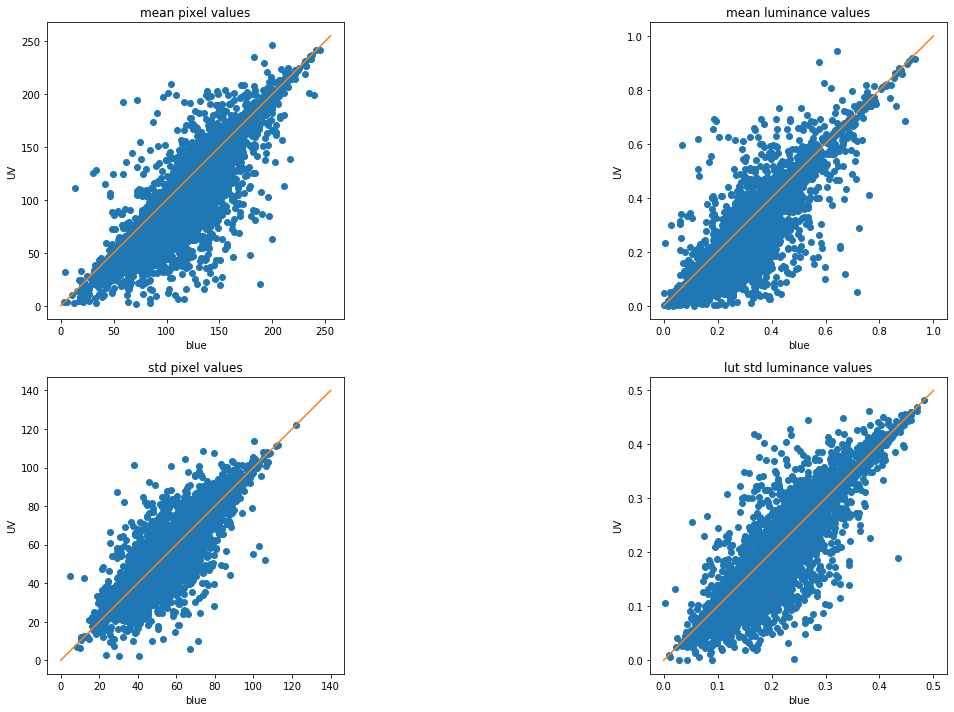

In [26]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

# plt.gca().set_aspect('equal', adjustable='box')

ax[0][0].plot(blue['mean'],uv['mean'],'o')
ax[0][0].plot([0,255],[0,255])
ax[0][0].set_xlabel('blue')
ax[0][0].set_ylabel('UV')
ax[0][0].set_title('mean pixel values')
ax[0][0].set(aspect='equal')


ax[0][1].plot(blue['lut_mean'],uv['lut_mean'],'o')
ax[0][1].plot([0,1],[0,1])
ax[0][1].set_xlabel('blue')
ax[0][1].set_ylabel('UV')
ax[0][1].set_title('mean luminance values')
ax[0][1].set(aspect='equal')

ax[1][0].plot(blue['std'],uv['std'],'o')
ax[1][0].plot([0,140],[0,140])
ax[1][0].set_xlabel('blue')
ax[1][0].set_ylabel('UV')
ax[1][0].set_title('std pixel values')
ax[1][0].set(aspect='equal')

ax[1][1].plot(blue['lut_std'],uv['lut_std'],'o')
ax[1][1].plot([0,1/2],[0,1/2])
ax[1][1].set_xlabel('blue')
ax[1][1].set_ylabel('UV')
ax[1][1].set_title('lut std luminance values')
ax[1][1].set(aspect='equal')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

# plt.gca().set_aspect('equal', adjustable='box')

ax[0][0].plot(blue['mean'],uv['mean'],'o')
ax[0][0].plot([0,255],[0,255])
ax[0][0].set_xlabel('blue')
ax[0][0].set_ylabel('UV')
ax[0][0].set_title('mean pixel values')
ax[0][0].set(aspect='equal')


ax[0][1].plot(blue['lut_mean'],uv['lut_mean'],'o')
ax[0][1].plot([0,1],[0,1])
ax[0][1].set_xlabel('blue')
ax[0][1].set_ylabel('UV')
ax[0][1].set_title('mean luminance values')
ax[0][1].set(aspect='equal')

ax[1][0].plot(blue['std'],uv['std'],'o')
ax[1][0].plot([0,140],[0,140])
ax[1][0].set_xlabel('blue')
ax[1][0].set_ylabel('UV')
ax[1][0].set_title('std pixel values')
ax[1][0].set(aspect='equal')

ax[1][1].plot(blue['lut_std'],uv['lut_std'],'o')
ax[1][1].plot([0,1/2],[0,1/2])
ax[1][1].set_xlabel('blue')
ax[1][1].set_ylabel('UV')
ax[1][1].set_title('lut std luminance values')
ax[1][1].set(aspect='equal')

plt.tight_layout()

In [33]:
from scipy import stats

In [88]:
for _kind in ['lut_std','lut_mean']:
    _, pval = stats.ks_2samp(blue[_kind], uv[_kind])
    print('For {0}, pval of Kolmogorov-Smirnov test between two channels is {1}'.format(_kind, pval))

For lut_std, pval of Kolmogorov-Smirnov test between two channels is 7.318756335676448e-19
For lut_mean, pval of Kolmogorov-Smirnov test between two channels is 5.302203993427959e-71


In [89]:
print(_)

0.1780392156862745


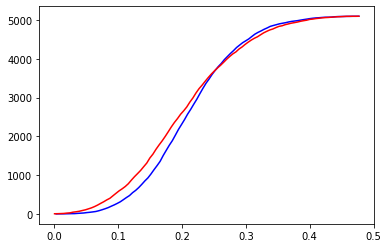

In [87]:
values, base = np.histogram(blue['lut_std'], bins=100)
values1, base1 = np.histogram(uv['lut_std'], bins=100)
#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative1 = np.cumsum(values1)

# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base1[:-1], cumulative1, c='red')

In [75]:
import seaborn as sns
import pandas as pd

In [76]:
data = np.vstack((blue['lut_mean'],uv['lut_mean'],blue['lut_std'],uv['lut_std'])).T

In [77]:

df = pd.DataFrame(data=data, index=[i for i in range(data.shape[0])],columns=['blue_lut_mean','uv_lut_mean','blue_lut_std','uv_lut_std'])

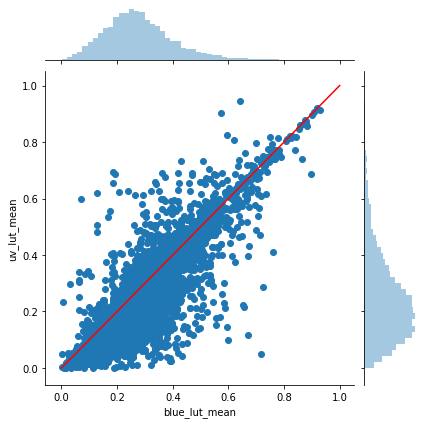

In [99]:
graph = sns.jointplot(x='blue_lut_mean',y='uv_lut_mean',data=df)

graph.x = [0,1]
graph.y = [0,1]
graph.plot_joint(plt.plot, c='r')

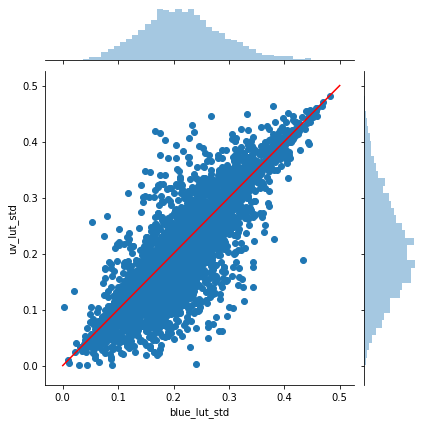

In [102]:
graph = sns.jointplot(x='blue_lut_std',y='uv_lut_std',data=df)

graph.x = [0,0.5]
graph.y = [0,0.5]
graph.plot_joint(plt.plot, c='r')

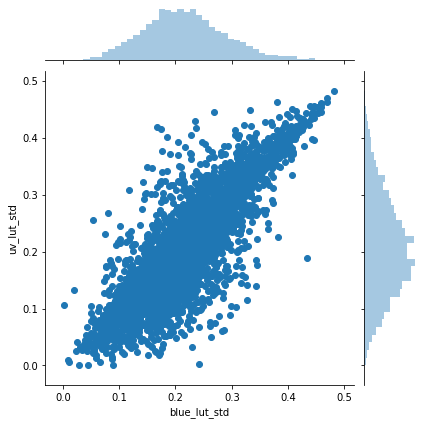

In [80]:
sns.jointplot(x='blue_lut_std',y='uv_lut_std',data=df)

In [104]:
for _kind in ['lut_std','lut_mean']:
    _, pval = stats.ks_2samp(blue[_kind], uv[_kind])
    print('For {0}, pval of Kolmogorov-Smirnov test between two channels is {1}'.format(_kind, pval))

For lut_std, pval of Kolmogorov-Smirnov test between two channels is 7.318756335676448e-19
For lut_mean, pval of Kolmogorov-Smirnov test between two channels is 5.302203993427959e-71
